In [1]:
from __future__ import division

import json
import base64
import random
from collections import Counter
import os.path
import imp
import gzip

import sys
import csv
import gc

import numpy as np
import pandas as pd


# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt


import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [2]:
def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

In [3]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    
    titles = u''
    for title in soup.find_all('title'):
        titles += title.string + u' ' if title.string else u''
        
    links = []
    anchors = u''
    for tag in soup.find_all('a'):
        anchors += tag.string + u' ' if tag.string else u''
        try:
            links.append(tag['href'])
        except KeyError:
            pass
        
    keywords = u''
    for key in soup.find_all("meta", attrs={"name":"keywords"}):
        try:
            keywords += key['content'] + u' ' if key['content'] else u''
        except KeyError:
            pass
        
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text(), titles, anchors, links, keywords

In [4]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

In [5]:
def html2word(raw_html, to_text=html2text_bs, tokenizer=easy_tokenizer):
    text, title, anchors, links, keywords = to_text(raw_html)
    return list(tokenizer(text.lower())), list(tokenizer(title.lower())), \
        list(tokenizer(anchors.lower())), links, list(tokenizer(keywords.lower()))

In [6]:
def file2docs_csv(input_file_name, reparse=False):    
    result = []
    
    if os.path.exists(input_file_name + ".json") and not reparse:
        logging.info("File %s.json already exists - load it" % input_file_name)
        result = json.load(open(input_file_name + ".json", 'rb'))
    else:                                
        with gzip.open(input_file_name) if input_file_name.endswith('gz') \
            else open(input_file_name)  as input_file:            
            headers = input_file.readline()
            try:
                for i, line in enumerate(input_file):

                    parts = line.strip().split('\t')
                    url_id = int(parts[0])                                        
                    mark = bool(int(parts[1]))                    
                    url = parts[2]
                    pageInb64 = parts[3]
                    html_data = base64.b64decode(pageInb64)                
                    words, title, anchors, links, keywords = html2word(html_data)

                    result.append( (url_id, mark, url, words, title, anchors, links, keywords))  
                    if i % 100 == 0: logging.info("Complete %04d" % i)
            except:
                print i, parts                
                raise

                    
        logging.info("Complete %04d" % i)
        logging.info("Create json dump %s" % (input_file_name + ".json"))
        json.dump(result, open(input_file_name + ".json", 'wb'))
    return result

In [7]:
import sys
import zlib

def calc_stats(words, title, anchors):
    words_str = ''.join(words).encode('utf-8')
    compress_coeff = sys.getsizeof(zlib.compress(words_str)) * 1.0 /sys.getsizeof(words_str)
    
    return [len(words), np.mean(map(len, words)),
            len(title), len(anchors),
            compress_coeff]

In [8]:
def get_n_grams(url, window=5):
    return set(url[i:i+window] for i in range(0, len(url) - window, 1))

In [9]:
from urllib import unquote
from urlparse import urlparse
import re

def parse_url(url):
    url_parsed = urlparse(url)
    parts = [] 
    parts.extend(url_parsed.netloc.split('.'))
    parts.extend(re.split(r'[-_/.]', url_parsed.path))
    return [p for p in parts if p != '']

url = u'http://whistkeruso.narod.ru/prostitutki-shlyuhi-deshevie-moskvi.html'
parse_url(url)

[u'whistkeruso',
 u'narod',
 u'ru',
 u'prostitutki',
 u'shlyuhi',
 u'deshevie',
 u'moskvi',
 u'html']

## Experiments

In [10]:
TRAIN_DATA_FILE  = 'kaggle/kaggle_train_data_tab.csv.gz'
train_docs = file2docs_csv(TRAIN_DATA_FILE, reparse=False)

23:30:04 INFO:File kaggle/kaggle_train_data_tab.csv.gz.json already exists - load it


In [11]:
len(train_docs)

7044

In [12]:
random.shuffle(train_docs)

In [13]:
titles      = {'train': [], 'test': []}
urls_raw    = {'train': [], 'test': []}
# keywords    = {'train': [], 'test': []}

### FEATURE: stats

In [14]:
X_train, Y_train = [], []

for doc in train_docs[:6000]:
    doc_id, is_spam, url, words_, title, anchors, links, keywords_ = doc
    
    title = [w[:5] for w in title]
    
    X_train.append(calc_stats(words_, title, anchors))
    
    titles['train'].append(' '.join(title))
    urls_raw['train'].append(url)
    # keywords['train'].append(' '.join(keywords_))
    
    Y_train.append(is_spam)
    
X_train = np.asarray(X_train)

In [15]:
X_test, Y_test = [], []

for doc in train_docs[6000:]:
    doc_id, is_spam, url, words_, title, anchors, links, keywords_ = doc
    
    title = [w[:5] for w in title]
    
    X_test.append(calc_stats(words_, title, anchors))
    
    titles['test'].append(' '.join(title))
    urls_raw['test'].append(url)
    # keywords['test'].append(' '.join(keywords_))
    
    Y_test.append(is_spam)
    
X_test = np.asarray(X_test)

In [16]:
def plot_feature(label, column, bins):    
    plt.figure()
    plt.hist(
        np.append(
            X_train[np.where(np.asarray(Y_train, dtype=int) == 1)[0], column],
            X_test[np.where(np.asarray(Y_test, dtype=int) == 1)[0], column]
        ),
        color='red', alpha=0.5, label="Spam",
        bins=bins
    )
    
    plt.hist(
        np.append(
            X_train[np.where(np.asarray(Y_train, dtype=int) == 0)[0], column],
            X_test[np.where(np.asarray(Y_test, dtype=int) == 0)[0], column]
        ),
        color='blue', alpha=0.5, label="NotSpam",
        bins=bins
    )
    
    if column == -1:
        label = label + ', ' + str(X_train.shape[1]-1)
    else:
        label = label + ', ' + str(column)
        
    plt.title(label)
    plt.legend()
    plt.show()

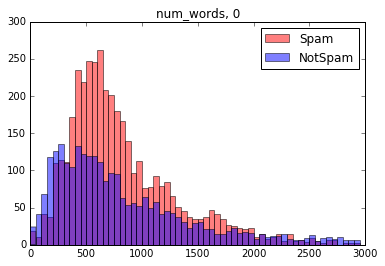

In [17]:
plot_feature('num_words', 0, range(0, 3000, 50))

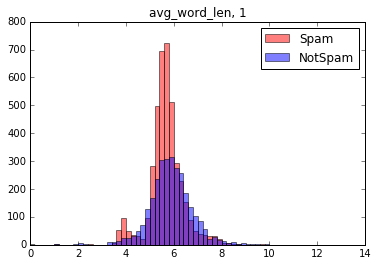

In [18]:
plot_feature('avg_word_len', 1, np.arange(0, 14, 0.2))

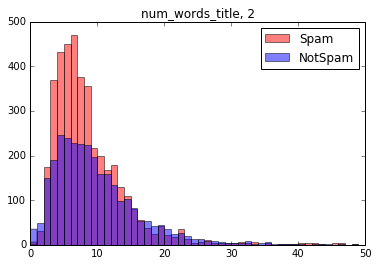

In [19]:
plot_feature('num_words_title', 2, range(0, 50, 1))

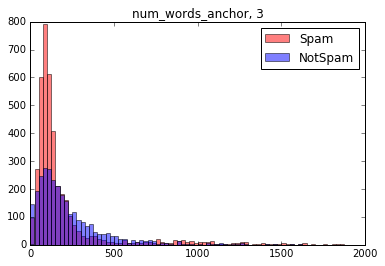

In [20]:
plot_feature('num_words_anchor', 3, range(0, 2000, 25))

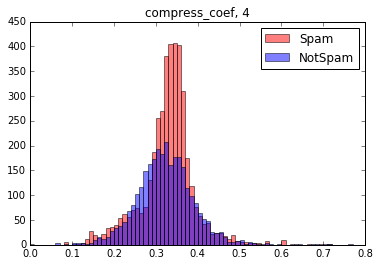

In [21]:
plot_feature('compress_coef', 4, np.arange(0, 0.8, 0.01))

### FEATURE: title

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

vec = TfidfVectorizer()
# vec = CountVectorizer()

feature_train = vec.fit_transform(titles['train'])
feature_test  = vec.transform(titles['test'])

feature_indexes = np.where(feature_train.sum(axis=0) > 10.0)[1]

feature_train = feature_train[:, feature_indexes]
feature_test  = feature_test[:, feature_indexes]

In [23]:
feature_train.shape[1]

437

In [24]:
X_train = np.hstack((X_train, feature_train.toarray()))
X_test  = np.hstack((X_test, feature_test.toarray()))

### FEATURE: most frequent words

In [25]:
words_all = []

for doc in train_docs[:6000]:
    doc_id, is_spam, url, words_, title, anchors, links, keywords_ = doc
    words_all.append(' '.join(words_))

for doc in train_docs[6000:]:
    doc_id, is_spam, url, words_, title, anchors, links, keywords_ = doc
    words_all.append(' '.join(words_))

In [26]:
vec = CountVectorizer()

words_all = vec.fit_transform(words_all)
words_all.shape

(7044, 647952)

In [27]:
n = 700.0

words_most_frequent = np.asarray(words_all.sum(axis=0)).reshape(-1)
words_most_frequent = words_most_frequent.argsort()[-int(n):]
words_most_frequent.sort()

feature_train = words_all[:6000, words_most_frequent]
feature_train = feature_train.sum(axis=1)
feature_train = np.asarray(feature_train)

feature_test = words_all[6000:, words_most_frequent]
feature_test = feature_test.sum(axis=1)
feature_test = np.asarray(feature_test)

In [28]:
X_train = np.hstack((X_train, feature_train))
X_test  = np.hstack((X_test, feature_test))

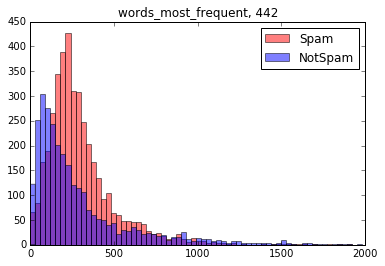

In [29]:
plot_feature('words_most_frequent', -1, np.arange(0, 2000, 3e1))

In [30]:
feature_train = words_all[:6000, words_most_frequent]
feature_train /= feature_train
feature_train = np.nan_to_num(feature_train)
feature_train = feature_train.mean(axis=1)
feature_train = np.asarray(feature_train)

feature_test = words_all[6000:, words_most_frequent]
feature_test /= feature_test
feature_test = np.nan_to_num(feature_test)
feature_test = feature_test.mean(axis=1)
feature_test = np.asarray(feature_test)

In [31]:
X_train = np.hstack((X_train, feature_train))
X_test  = np.hstack((X_test, feature_test))

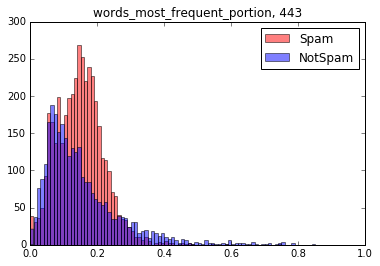

In [32]:
plot_feature('words_most_frequent_portion', -1, np.arange(0, 1, .01))

In [33]:
vec = TfidfTransformer()

vec.fit(words_all[:, words_most_frequent])

feature_train = vec.transform(words_all[:6000, words_most_frequent])
feature_test  = vec.transform(words_all[6000:, words_most_frequent])

In [34]:
feature_train.shape[1]

700

In [35]:
X_train = np.hstack((X_train, feature_train.toarray()))
X_test  = np.hstack((X_test, feature_test.toarray()))

In [36]:
del words_all

### FEATURE: ngrams independence

In [37]:
def measure_ngram_independence(ngrams):
    probs = np.asarray(Counter(ngrams).values(), dtype=float) / len(ngrams)
    measure = -np.mean(np.log(probs))
    return measure

In [38]:
feature_train = []
    
for doc in train_docs[:6000]:
    doc_id, is_spam, url, words_, title, anchors, links, keywords_ = doc
    ngr = get_n_grams(' '.join(words_), window=7)
    feature_train.append(measure_ngram_independence(ngr))
    
feature_train = np.asarray(feature_train).reshape(-1, 1)

feature_test  = []

for doc in train_docs[6000:]:
    doc_id, is_spam, url, words_, title, anchors, links, keywords_ = doc
    ngr = get_n_grams(' '.join(words_), window=7)
    feature_test.append(measure_ngram_independence(ngr))

feature_test = np.asarray(feature_test).reshape(-1, 1)

In [39]:
X_train = np.hstack((X_train, feature_train))
X_test  = np.hstack((X_test, feature_test))

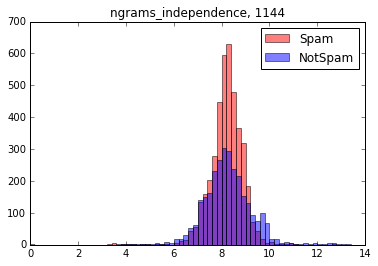

In [40]:
plot_feature('ngrams_independence', -1, np.arange(0, 14, .2))

### FEATURE: anchor links inside domen

In [41]:
feature_train = []

for doc in train_docs[:6000]:
    doc_id, is_spam, url, words_, title, anchors, links, keywords_ = doc
    try:
        feature_train.append(
            map(lambda x: urlparse(x).netloc, links).count(urlparse(url).netloc) / float(len(links))
        )
    except ZeroDivisionError:
        feature_train.append(0)
        
feature_test = []

for doc in train_docs[6000:]:
    doc_id, is_spam, url, words_, title, anchors, links, keywords_ = doc
    try:
        feature_test.append(
            map(lambda x: urlparse(x).netloc, links).count(urlparse(url).netloc) / float(len(links))
        )
    except ZeroDivisionError:
        feature_test.append(0)

In [42]:
feature_train = np.asarray(feature_train).reshape(-1, 1)
feature_test  = np.asarray(feature_test).reshape(-1, 1)

In [43]:
X_train = np.hstack((X_train, feature_train))
X_test  = np.hstack((X_test, feature_test))

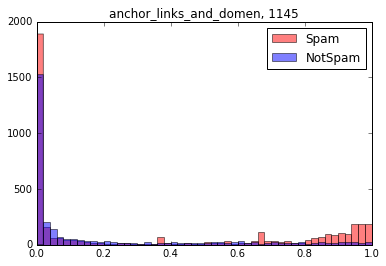

In [44]:
plot_feature('anchor_links_and_domen', -1, 50)

### FEATURE: words in urls

In [45]:
vec = CountVectorizer()

feature_train = vec.fit_transform(map(lambda x: ' '.join(parse_url(x)), urls_raw['train']))
feature_test  = vec.transform(map(lambda x: ' '.join(parse_url(x)), urls_raw['test']))

feature_indexes = np.where(feature_train.sum(axis=0) > 10.0)[1]

feature_train = feature_train[:, feature_indexes]
feature_test  = feature_test[:, feature_indexes]

In [46]:
feature_train.shape[1]

300

In [47]:
X_train = np.hstack((X_train, feature_train.toarray()))
X_test  = np.hstack((X_test, feature_test.toarray()))

### FEATURE: urls ratio

In [48]:
def url_ratio(url):    
    url_parsed = urlparse(url)
    parts = re.split(r'[-_/.]', url_parsed.path)
    
    parts = np.asarray([len(p) for p in parts if p != ''], dtype=float)
    if len(parts) == 0:
        return 0
    return np.mean(parts / len(url))

In [49]:
feature_train = np.asarray(map(url_ratio, urls_raw['train'])).reshape(-1, 1)
feature_test  = np.asarray(map(url_ratio, urls_raw['test'])).reshape(-1, 1)

In [50]:
X_train = np.hstack((X_train, feature_train))
X_test  = np.hstack((X_test, feature_test))

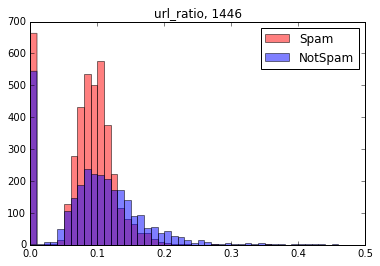

In [51]:
plot_feature('url_ratio', -1, np.arange(0, .5, .01))

In [52]:
def url_ratio(url):    
    url_parsed = urlparse(url)
    parts = re.split(r'[/]', url_parsed.path)
    return len(parts)

In [53]:
feature_train = np.asarray(map(url_ratio, urls_raw['train'])).reshape(-1, 1)
feature_test  = np.asarray(map(url_ratio, urls_raw['test'])).reshape(-1, 1)

In [54]:
X_train = np.hstack((X_train, feature_train))
X_test  = np.hstack((X_test, feature_test))

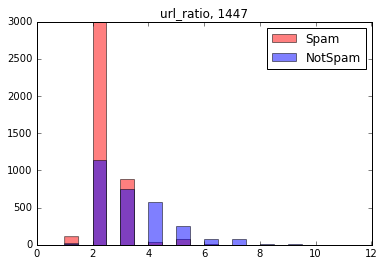

In [55]:
plot_feature('url_ratio', -1, np.arange(1, 11, .5))

In [56]:
def url_ratio(url):    
    url_parsed = urlparse(url)
    parts = re.split(r'[/]', url_parsed.path)
    return np.mean(map(len, parts))

In [57]:
feature_train = np.asarray(map(url_ratio, urls_raw['train'])).reshape(-1, 1)
feature_test  = np.asarray(map(url_ratio, urls_raw['test'])).reshape(-1, 1)

In [58]:
X_train = np.hstack((X_train, feature_train))
X_test  = np.hstack((X_test, feature_test))

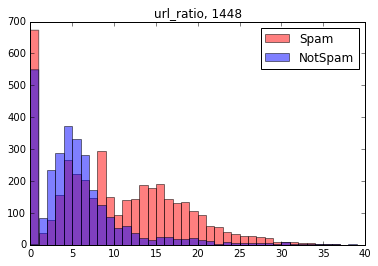

In [59]:
plot_feature('url_ratio', -1, np.arange(0, 40, 1))

In [60]:
def url_ratio(url):    
    url_parsed = urlparse(url)
    parts = re.split(r'[/_]', url_parsed.path)
    
    parts = np.asarray([len(p) for p in parts if p != ''], dtype=float)
    if len(parts) == 0:
        return 0
    return np.mean(parts / len(url))

In [61]:
feature_train = np.asarray(map(url_ratio, urls_raw['train'])).reshape(-1, 1)
feature_test  = np.asarray(map(url_ratio, urls_raw['test'])).reshape(-1, 1)

In [62]:
X_train = np.hstack((X_train, feature_train))
X_test  = np.hstack((X_test, feature_test))

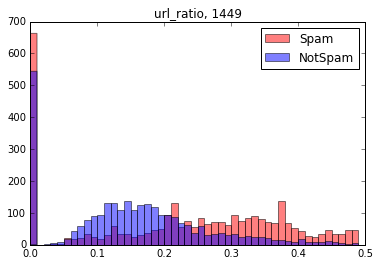

In [63]:
plot_feature('url_ratio', -1, np.arange(0, .5, .01))

In [64]:
def url_ratio(url):    
    url_parsed = urlparse(url)
    parts = re.split(r'[/_]', url_parsed.path)
    return len(parts)

In [65]:
feature_train = np.asarray(map(url_ratio, urls_raw['train'])).reshape(-1, 1)
feature_test  = np.asarray(map(url_ratio, urls_raw['test'])).reshape(-1, 1)

In [66]:
X_train = np.hstack((X_train, feature_train))
X_test  = np.hstack((X_test, feature_test))

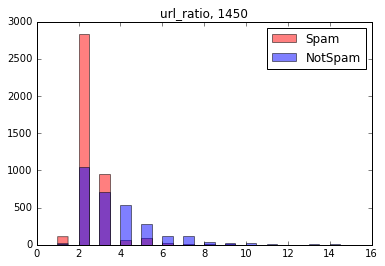

In [67]:
plot_feature('url_ratio', -1, np.arange(1, 15, .5))

In [68]:
def url_ratio(url):
    url_parsed = urlparse(url)
    return len(url_parsed.netloc) / float(len(url))

In [69]:
feature_train = np.asarray(map(url_ratio, urls_raw['train'])).reshape(-1, 1)
feature_test  = np.asarray(map(url_ratio, urls_raw['test'])).reshape(-1, 1)

In [70]:
X_train = np.hstack((X_train, feature_train))
X_test  = np.hstack((X_test, feature_test))

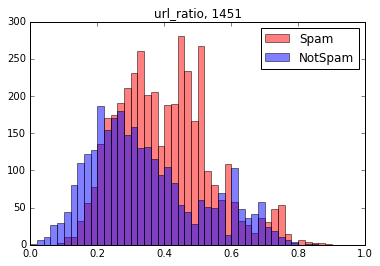

In [71]:
plot_feature('url_ratio', -1, np.arange(0, 1, .02))

In [72]:
def url_ratio(url):    
    url_parsed = urlparse(url)
    parts = re.split(r'[-]', url_parsed.path)
    return len(parts)

In [73]:
feature_train = np.asarray(map(url_ratio, urls_raw['train'])).reshape(-1, 1)
feature_test  = np.asarray(map(url_ratio, urls_raw['test'])).reshape(-1, 1)

In [74]:
X_train = np.hstack((X_train, feature_train))
X_test  = np.hstack((X_test, feature_test))

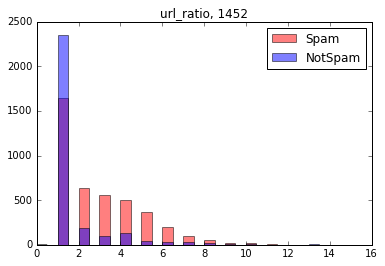

In [75]:
plot_feature('url_ratio', -1, np.arange(0, 15, .5))

In [76]:
def url_ratio(url):    
    url_parsed = urlparse(url)
    parts = re.split(r'[-]', url_parsed.path)
    return np.mean(map(len, parts))

In [77]:
feature_train = np.asarray(map(url_ratio, urls_raw['train'])).reshape(-1, 1)
feature_test  = np.asarray(map(url_ratio, urls_raw['test'])).reshape(-1, 1)

In [78]:
X_train = np.hstack((X_train, feature_train))
X_test  = np.hstack((X_test, feature_test))

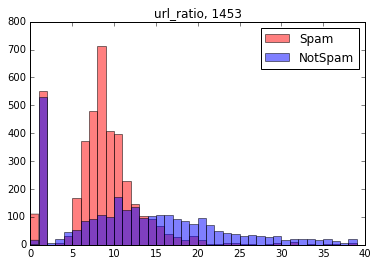

In [79]:
plot_feature('url_ratio', -1, np.arange(0, 40, 1))

### PREDICTION

In [80]:
X_train.shape, X_test.shape

((6000, 1454), (1044, 1454))

In [81]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

cl = GBC(learning_rate=0.3, max_depth=7, n_estimators=100)
cl.fit(X_train, Y_train)

GradientBoostingClassifier(init=None, learning_rate=0.3, loss='deviance',
              max_depth=7, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [82]:
Y_pred = cl.predict(X_test)

In [83]:
from sklearn.metrics import f1_score

f1_score(Y_test, Y_pred, average='binary')

0.97643097643097643

In [84]:
importance = cl.feature_importances_
importance.argsort()[-100:][::-1]

array([1451, 1286,  472, 1383,    3, 1449,  473, 1448, 1004,  442,  839,
          1, 1453, 1342,    4,  522, 1145, 1446, 1435,    0,  841, 1321,
       1447, 1284,  914,  793,  521,  741, 1029, 1288,  319,  903,  686,
       1450,  985,  497,  997, 1121,  640,  454,  250,  796,  854,  900,
       1144, 1452,  539,  818, 1413, 1044,  829,  716,  457,  444,  362,
        687, 1346,  901,  206,  160, 1062,  190,  443,  862,  780,  524,
       1372, 1123,  746,  608,  711,  469,   62,  455,  830,  866,  322,
       1026, 1083,  321,  888,  508,  920, 1349,  320,   25,  855,  558,
        761, 1285,  863,  939,  448, 1100, 1118,  258,  565,  541,  884,
       1241])

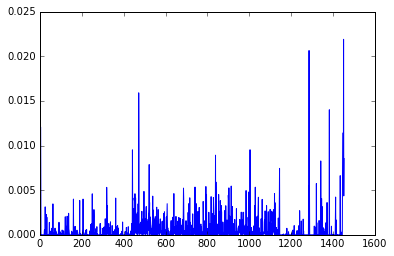

In [86]:
plt.plot(importance)